In [2]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from keras.models import load_model
import pickle
import time

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn')

C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#Como tenemos procesado todo en el mismo fichero, lo cargamos

path = '../Entrenamientos/Procesado_Tramos.xlsx'
df = pd.read_excel(path)

In [4]:
#Eliminar las filas que no tienen datos y seleccionamos la prueba que queremos simular

#df = df[df["viento_aparente"]!=-np.inf]
df = df[df["porc"]!=np.inf]
#df["puntos_en_tramo"]= df["tramo_final"]-df["tramo_inicial"]
#df = df[df["puntos_en_tramo"]>250]
#df = df[df["porc"]>2]
df = df[df["prueba"]=="20180429_LEMG_195_90_R_C.gpx"]

In [5]:
df.describe()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,60.500000,3496.016393,3547.770492,207.940679,94.262295,726.590164,35.150620,-1.333628,0.058167,49403.237132
std,35.362409,1946.877241,1937.072375,52.063138,172.804471,1130.014691,12.474903,13.483191,2.092644,27074.087892
min,0.000000,0.000000,16.000000,22.992004,1.000000,9.697469,12.922105,-14.992324,-6.597866,173.532309
25%,30.250000,2196.750000,2230.750000,180.272469,7.000000,61.750000,26.661969,-14.375875,-0.870941,30967.492612
50%,60.500000,3286.500000,3353.500000,223.516007,50.500000,466.777042,33.203336,-6.759451,0.003106,47158.500000
75%,90.750000,5248.500000,5283.500000,241.060519,92.750000,847.570583,41.207362,14.235446,0.859900,72401.000000
max,121.000000,6300.000000,6314.000000,299.800000,1158.000000,8788.000000,75.302316,14.918299,7.046886,88630.000000


In [6]:
#Se revisa que no existan datos anómalos
df.head()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum,prueba
0,0,0,16,196.808012,17,187.41664,39.688230,14.918299,-0.399565,173.532309,20180429_LEMG_195_90_R_C.gpx
1,1,16,75,230.996299,98,886.58336,32.568368,14.577416,0.523132,1055.000000,20180429_LEMG_195_90_R_C.gpx
2,2,75,122,194.043315,60,616.40000,36.984000,14.550887,-0.240187,1677.304307,20180429_LEMG_195_90_R_C.gpx
3,3,122,227,221.693546,193,1692.60000,31.571813,14.552940,0.895103,3364.000000,20180429_LEMG_195_90_R_C.gpx
4,4,227,273,169.324586,47,538.40000,41.239149,14.433466,-1.235191,3911.000000,20180429_LEMG_195_90_R_C.gpx


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  2.,  0.,  0.,  1.,  1.,
         0.,  3.,  0.,  0.,  1.,  0.,  2.,  1.,  3.,  1.,  0.,  1.,  4.,
         3.,  2.,  1.,  1.,  3.,  1.,  3.,  3., 11., 18.,  8.,  1.,  3.,
         3.,  3.,  4.,  1.,  2.,  1.,  2.,  1.,  0.,  1.,  1.,  2.,  1.,
         1.,  1.,  1.,  1.,  2.,  3.,  2.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-6.59786614, -6.46141862, -6.32497111, -6.18852359, -6.05207607,
        -5.91562855, -5.77918103, -5.64273351, -5.50628599, -5.36983847,
        -5.23339095, -5.09694343, -4.96049591, -4.82404839, -4.68760087,
        -4.55115335, -4.41470584, -4.27825832, -4.1418108 , -4.00536328,
        -3.86891576, -3.73246824, -3.59602072, -3.4595732 , -3.32312568,
        -3.18667816, -3.05023064, -2.91378312, -2.7773356 , -2.640888

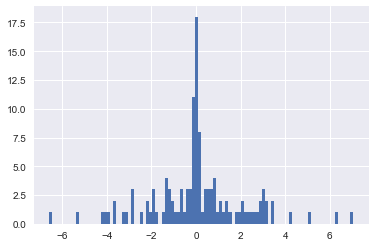

In [7]:
plt.hist(df['porc'],bins=100)

In [9]:
#Prueba iterando en cada tramo con intervalos aleatorios con el modelo desarrollado CON TENSORFLOW (PRIMERA PASADA)

#Almacenamos la hora de inicio para evaluar el tiempo que tarda en ejecutar
start_time = time.time()



#Cargamos los dos modelos con los que vamos a trabajar
pre_model = joblib.load('../Machine Learning/regr_porc_pwr.model') 

model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))



#Inicializamos las variables de control del flujo de ejecución
potencia_objetivo = 220
multiplicador_potencia = potencia_objetivo/pre_model.intercept_

resultados = []
fail = 0
exito = 0
num_pruebas = 50
fi = 0

pot_min = 50
pot_max = 300
ff_1 = 0.5
ff_2 = 0.5

#Repetimos la simulación de pruebas hasta que tenemos un número de existos concreto
while exito < num_pruebas:
    #print(exito)
    if (fi % 1000) == 0:
        print('Empezamos la prueba %d' %fi)
        print("--- %s seconds ---" % (time.time() - start_time))
    
    #Reiniciamos la varaibles para acumular cada prueba
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    
    #Simulamos cada tramo de la prueba uno a uno
    while i < len(df):
        
        #Recuperamis el porcentaje de la pendiente, el viento y la distancia
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
        
        #if porc < -2:
        #    potencia = pre_model.predict(porc)[0][0]*multiplicador_potencia+np.random.randint(-abs(porc), abs(porc))
        #elif porc > 2:
        #    #potencia = pre_model.predict(porc)[0][0]+50+np.random.randint(-abs(porc**2), abs(porc**2))
        #    potencia =potencia_objetivo+np.random.randint(0, abs(porc)+50)
        #else:
        #    potencia = potencia_objetivo+np.random.randint(-abs(porc)-10, abs(porc)+30)
        
        #potencia con una sigmoide
        #DAVID METE AQUI UNA EXPLICACION           
        potencia = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))+np.random.randint(-1*(abs(viento)**2+1), abs(viento)**2+1)
        
        #Utilizamos el modelo de normalización entrenado para ajustar los datos de entrada
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        #Utilizamos el modelo de Tensor Flow para predecir la velocidad media de ese tramo
        velocidad = model_TF.predict(input_model)[0]
        
        #Con la velocidad del paso anterior y la distancia del tramo, calculamos el tiempo necesario para recorrerlo
        nuevo_tiempo = distancia/(velocidad/3.6)
        #Almacenamos la información del paso actual
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        #Acumulamos la potencia y el tiempo para evaluar el resultado final y determinar si es éxito o no, y con que tiempo total
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        i += 1
    
    potencia_media = potencia_acum/tiempo_acum
    print("Intento %d con potencia media %d" %(fi, potencia_media))
    
    #Si la pontencia queda fuera de intervalos viables, no se considera como exito
    #Nos quedamos con +/-20w sobre la potencia objetivo para luego seleccionar las mejores distribuciones de potencia
    if (potencia_media > potencia_objetivo-20) and (potencia_media < potencia_objetivo+20):
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        #Contamos las simulaciones consideradas sin exito
        fail +=1
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos de favorables: %d' %(len(resultados)))

C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator LinearRegression from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator RobustScaler from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Empezamos la prueba 0
--- 0.7923309803009033 seconds ---
Intento 0 con potencia media 198
Intento 1 con potencia media 179
Intento 2 con potencia media 208
Intento 3 con potencia media 198
Intento 4 con potencia media 209
Intento 5 con potencia media 214
Intento 6 con potencia media 211
Intento 7 con potencia media 195
Intento 8 con potencia media 187
Intento 9 con potencia media 206
Intento 10 con potencia media 196
Intento 11 con potencia media 210
Intento 12 con potencia media 191
Intento 13 con potencia media 200
Intento 14 con potencia media 184
Intento 15 con potencia media 210
Intento 16 con potencia media 211
Intento 17 con potencia media 197
Intento 18 con potencia media 181
Intento 19 con potencia media 207
Intento 20 con potencia media 173
Intento 21 con potencia media 211
Intento 22 con potencia media 213
Intento 23 con potencia media 210
Intento 24 con potencia media 216
Intento 25 con potencia media 216
Intento 26 con potencia media 211
Intento 27 con potencia media 216
I

In [10]:
ds = pd.DataFrame(resultados)
ds.columns = ('intento','pwr','secs','list')
ds

,intento,pwr,secs,list
0,2,208.187912,9193.088867,"[[0, 190.2247007302421, 38.555157, 187.41664, ..."
1,4,209.075943,9390.381836,"[[0, 286.2247007302421, 47.835636, 187.41664, ..."
2,5,214.111282,9120.405273,"[[0, 134.2247007302421, 33.98536, 187.41664, 1..."
3,6,211.016983,9190.391602,"[[0, 16.22470073024209, 24.567278, 187.41664, ..."
4,9,206.811737,9422.843750,"[[0, 422.2247007302421, 60.982967, 187.41664, ..."
5,11,210.042664,9366.730469,"[[0, 332.2247007302421, 52.28252, 187.41664, 1..."
6,13,200.231064,9406.196289,"[[0, -0.7752992697579089, 23.16361, 187.41664,..."
7,15,210.223816,9117.029297,"[[0, 174.2247007302421, 37.15322, 187.41664, 1..."
8,16,211.781097,9307.666992,"[[0, 58.22470073024209, 27.93218, 187.41664, 2..."
9,19,207.566269,9208.544922,"[[0, 90.22470073024209, 30.49337, 187.41664, 2..."


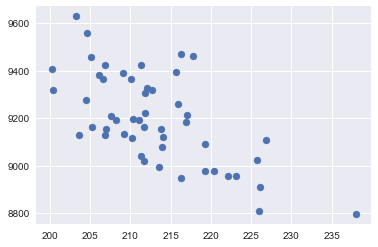

In [11]:
plt.scatter(ds['pwr'],ds['secs'])

In [ ]:
plt.hist(ds['pwr'],bins=50)

In [12]:
a = ds.groupby(['intento'])['secs'].agg('sum').sort_values(ascending=True)
a[:1].max()

8796.1826171875

In [13]:
ganadores = pd.DataFrame(ds[ds['secs']<=a[:50].max()][['intento','list']])
ganadores

,intento,list
0,2,"[[0, 190.2247007302421, 38.555157, 187.41664, ..."
1,4,"[[0, 286.2247007302421, 47.835636, 187.41664, ..."
2,5,"[[0, 134.2247007302421, 33.98536, 187.41664, 1..."
3,6,"[[0, 16.22470073024209, 24.567278, 187.41664, ..."
4,9,"[[0, 422.2247007302421, 60.982967, 187.41664, ..."
5,11,"[[0, 332.2247007302421, 52.28252, 187.41664, 1..."
6,13,"[[0, -0.7752992697579089, 23.16361, 187.41664,..."
7,15,"[[0, 174.2247007302421, 37.15322, 187.41664, 1..."
8,16,"[[0, 58.22470073024209, 27.93218, 187.41664, 2..."
9,19,"[[0, 90.22470073024209, 30.49337, 187.41664, 2..."


In [16]:
for i in range(len(ganadores)):
    if i == 0:
        df_ganador = pd.DataFrame(ganadores.values[i][1])
        df_ganador.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_ganador['Intento'] = ganadores.values[i][0]
    else:
        df_aux = pd.DataFrame(ganadores.values[i][1])
        df_aux.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_aux['Intento'] = ganadores.values[i][0]
        df_ganador = df_ganador.append([df_aux])
        del df_aux
df_ganador.to_excel('res_sim.xlsx')
df_ganador.head()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
0,0,190.224701,38.555157,187.41664,17.499601,-0.399565,14.918299,2
1,1,45.515508,24.020742,886.58336,132.872665,0.523132,14.577416,2
2,2,52.866869,26.697472,616.40000,83.117981,-0.240187,14.550887,2
3,3,364.451984,48.970196,1692.60000,124.429962,0.895103,14.552940,2
4,4,164.719745,40.365944,538.40000,48.016712,-1.235191,14.433466,2


In [23]:
df_input = df[['tramo','pwr','spd','dist','time_seg','porc','viento_aparente']]
df_input.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
df_input['Intento'] = 'Original'
df_input.head()

C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
0,0,196.808012,39.688230,187.41664,17,-0.399565,14.918299,Original
1,1,230.996299,32.568368,886.58336,98,0.523132,14.577416,Original
2,2,194.043315,36.984000,616.40000,60,-0.240187,14.550887,Original
3,3,221.693546,31.571813,1692.60000,193,0.895103,14.552940,Original
4,4,169.324586,41.239149,538.40000,47,-1.235191,14.433466,Original


In [24]:
df_input.append([df_ganador]).to_excel('res_sim_ori.xlsx')

ganadores.index.values

In [ ]:
potencias_medias = df_ganador.groupby(['Tramos'])['Potencia'].agg('median')
#.sort_values(ascending=True)
#mean

In [ ]:
potencias_medias[0]

In [ ]:
#CON TENSORFLOW (SEGUNDA PASADA)
start_time = time.time()

pre_model = joblib.load('../Machine Learning/regr_porc_pwr.model') 

model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))



potencia_objetivo = 220
multiplicador_potencia = potencia_objetivo/pre_model.intercept_

resultados = []
fail = 0
exito = 0
num_pruebas = 50
fi = 0


while exito < num_pruebas:
    #print(exito)
    if (fi % 1000) == 0:
        print('Empezamos la prueba %d' %fi)
        print("--- %s seconds ---" % (time.time() - start_time))
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    while i < len(df):
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
        
        #if porc < -2:
        #    potencia = pre_model.predict(porc)[0][0]*multiplicador_potencia+np.random.randint(-abs(porc), abs(porc))
        #elif porc > 2:
        #    #potencia = pre_model.predict(porc)[0][0]+50+np.random.randint(-abs(porc**2), abs(porc**2))
        #    potencia =potencia_objetivo+np.random.randint(0, abs(porc)+50)
        #else:
        #    potencia = potencia_objetivo+np.random.randint(-abs(porc)-10, abs(porc)+30)
        
        #potencia con una sigmoide
        #pot_min = 50
        #pot_max = 300
        #ff_1 = 0.5
        #ff_2 = 0.5
        
        #potencia = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))+np.random.randint(-10, 10)
        
        potencia = potencias_medias[i]+np.random.randint(-10, 10)
        
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        velocidad = model_TF.predict(input_model)[0]
        
        nuevo_tiempo = distancia/(velocidad/3.6)
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        i += 1
    potencia_media = potencia_acum/tiempo_acum
    print("Intento %d con potencia media %d" %(fi, potencia_media))
    
    if (potencia_media > potencia_objetivo-20) and (potencia_media < potencia_objetivo+20):
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        fail +=1
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos de favorables: %d' %(len(resultados)))